The aim of this notebook is to use PCA to explore whether there is a difference between the animal and non-animal dataset somewhere in the activations of LLama 7B 2 chat, and to identify where this difference is. 

In [1]:
import numpy as np
import random
import pandas as pd
import torch as t
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import os
%load_ext autoreload
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:64'

import utils

%autoreload 2

/Users/paul/anaconda3/envs/acd/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
# Load model and dataset
model = utils.HookedModel("openai-community/gpt2")
model.set_layers(model.model.transformer.h)

# Get dataset for constructing direction detector
dataset = utils.Dataset()
dataset.load_data('../datasets/ilikecats_20000.csv', 'Animal', 'Non-Animal')

# Get dataset for testing direction detector
test_dataset = dataset = utils.Dataset()
test_dataset.load_data('../datasets/(non)animal_2000.csv', 'Animal', 'Non-Animal')
num_samples = 64 // 2
test_data, labels = test_dataset.combine_dataset_get_labels(num_samples)

# Construct direction detector vector
num_samples = 64
batch_size = 64
max_length = None

animal_detection_vectors = model.calculate_detector_direction(dataset, num_samples, max_length, batch_size)

# Create test activations dataset

test_activations = model.get_last_token_activations(test_data, max_tokens = max_length, batch_size = batch_size)

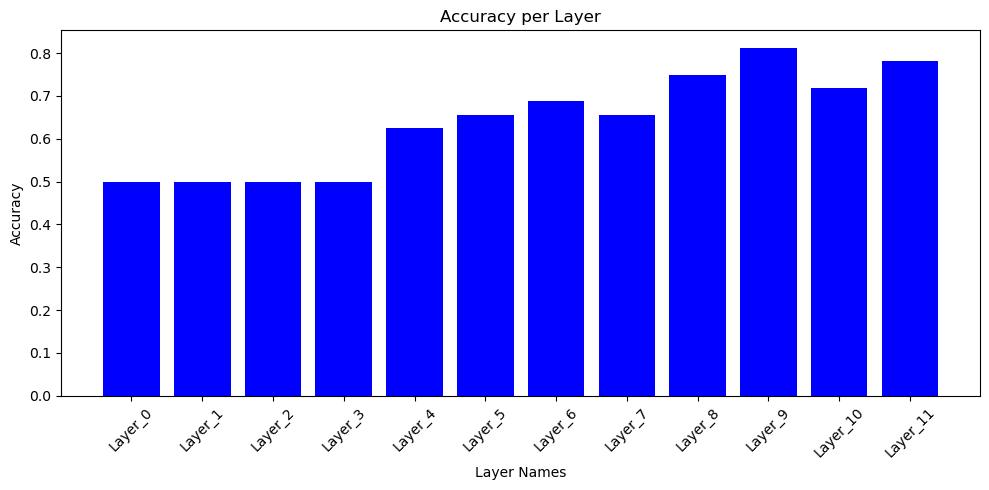

0.5
0.5
0.5
0.5
0.625
0.65625
0.6875
0.65625
0.75
0.8125
0.71875
0.78125


In [16]:
# Evaluate detector
accuracies = utils.evaluate_detector(test_activations, animal_detection_vectors, labels, model.layer_indices_to_track)
for acuracy in accuracies.values():
    print(acuracy)